<a href="https://colab.research.google.com/github/ashishawasthi/interpretability-perf/blob/main/indie/notebooks/SHAP_MLFlow_Breast_Cancer_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Malignant Classification for Breast Cancer
- Data: sklearn's inbuilt tabular 'Breast Cancer' dataset
- Model: XGBoost Binary Logistic GBTree

In [ ]:
!pip install -q shap mlflow

In [ ]:
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb

import shap  
import mlflow
import mlflow.xgboost

## Get Data

In [ ]:
(data, target) = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

# Train XGBoost Model

In [ ]:
# Trial 684 finished with value: 1.0 and parameters: {'booster': 'gbtree', 'lambda': 9.486459506468117e-08, 'alpha': 0.0037354186942877192, 'subsample': 0.7853397902847841, 'colsample_bytree': 0.6950434423638863, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.00011024840905218627, 'gamma': 0.00022646303948284727, 'grow_policy': 'depthwise'}. Best is trial 684 with value: 1.0.

hparams = {
    "verbosity": 0,
    "objective": "binary:logistic",
    "tree_method": "exact",
    "booster": "gbtree",
    "lambda": 9.486459506468117e-08,# L2 reg
    "alpha": 0.0037354186942877192,# L1 reg
    "subsample": 0.7853397902847841,# sampling ratio
    "colsample_bytree": 0.6950434423638863,
    "max_depth": 3,
    "min_child_weight": 2,
    "eta": 0.00011024840905218627,
    "gamma": 0.00022646303948284727,
    "grow_policy": "depthwise"
}

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(data, target, test_size=0.25)
dtrain = xgb.DMatrix(train_X, label=train_y)
dvalid = xgb.DMatrix(val_X, label=val_y)
clf = xgb.train(hparams, dtrain)

# Predict & Evaluate

In [ ]:
preds = clf.predict(dvalid)
pred_labels = np.rint(preds)
accuracy = sklearn.metrics.accuracy_score(val_y, pred_labels)
print('Accuracy', accuracy)
f1_score = sklearn.metrics.f1_score(val_y, pred_labels)
print('F1 Score', f1_score)


Accuracy 0.9300699300699301
F1 Score 0.9456521739130435


In [ ]:
import timeit

time_in_fi_by_gain = timeit.timeit('feature_importances_by_gain = clf.get_score(importance_type="gain")', globals=globals(), number=1)
print(time_in_fi_by_gain)

0.0004668000001402106


In [ ]:
feature_importances_by_gain = clf.get_score(importance_type="gain")
print(feature_importances_by_gain)

{'worst perimeter': 174.377433645, 'worst compactness': 9.609929392000002, 'mean concavity': 16.13175369777778, 'worst texture': 15.177324309999998, 'worst smoothness': 6.71862793, 'worst area': 48.65907613666667, 'worst concave points': 50.49536028285714, 'mean texture': 7.52960253, 'worst radius': 231.59686899999997, 'mean concave points': 3.555282595, 'mean radius': 2.57495117, 'area error': 1.36366272, 'mean fractal dimension': 1.9904952, 'radius error': 5.1548843374999995, 'worst concavity': 3.58985901, 'concave points error': 7.98147297}


In [ ]:
import json
file_gfig = "global_feature_importances_by_gain.json"
with mlflow.start_run() as mlflow_run:
    mlflow_run_id = mlflow_run.info.run_id
    print(mlflow_run_id)
    mlflow.log_metrics({"accuracy": accuracy, 
                        'f1_score': f1_score,
                        'time_in_fi_by_gain': time_in_fi_by_gain
                        })
    with open(file_gfig, "w") as outfile:
        json.dump(feature_importances_by_gain, outfile)
    mlflow.log_artifact("global_feature_importances_by_gain.json", artifact_path="fi")
    #mlflow.log_metrics(feature_importances_by_gain)
    #mlflow.shap.log_explanation(lambda X: clf.predict(X), pred_labels)
    mlflow.end_run()

1ae48f5c0f5f4a5dbc488a1f2e5e5cf7


In [ ]:
mlflow_client = mlflow.tracking.MlflowClient()
run_data_dict = mlflow_client.get_run(mlflow_run_id).data.to_dictionary()
print(run_data_dict)

{'metrics': {'time_in_fi_by_gain': 0.0004668000001402106, 'accuracy': 0.9300699300699301, 'f1_score': 0.9456521739130435}, 'params': {}, 'tags': {'mlflow.source.name': '/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py', 'mlflow.user': 'root', 'mlflow.source.type': 'LOCAL'}}


In [ ]:
print(mlflow_client.list_artifacts(mlflow_run_id))

[<FileInfo: file_size=None, is_dir=True, path='fi'>]


In [ ]:
import os
artifact_dir = mlflow_client.list_artifacts(mlflow_run_id)[0].path
print("artifact_dir:", artifact_dir)
artifacts = mlflow_client.list_artifacts(mlflow_run.info.run_id, artifact_dir)
print("Artifact Files:", [art.path for art in artifacts])
artifact_dir_path = os.path.join(mlflow_run.info.artifact_uri.replace("file://", ""), artifact_dir)
#artifact_dir_path = mlflow_client.download_artifacts(mlflow_run.info.run_id, artifact_dir)
print("Artifact Path:", artifact_dir_path)

artifact_dir: fi
Artifact Files: ['fi/feature_importances_by_gain.json']
Artifact Path: /content/mlruns/0/1ae48f5c0f5f4a5dbc488a1f2e5e5cf7/artifacts/fi


In [ ]:
fis_json_path = os.path.join(artifact_dir_path, file_gfig)
with open(fis_json_path) as json_file:
    fis_json = json.load(json_file)
    print(fis_json)

{'worst perimeter': 174.377433645, 'worst compactness': 9.609929392000002, 'mean concavity': 16.13175369777778, 'worst texture': 15.177324309999998, 'worst smoothness': 6.71862793, 'worst area': 48.65907613666667, 'worst concave points': 50.49536028285714, 'mean texture': 7.52960253, 'worst radius': 231.59686899999997, 'mean concave points': 3.555282595, 'mean radius': 2.57495117, 'area error': 1.36366272, 'mean fractal dimension': 1.9904952, 'radius error': 5.1548843374999995, 'worst concavity': 3.58985901, 'concave points error': 7.98147297}


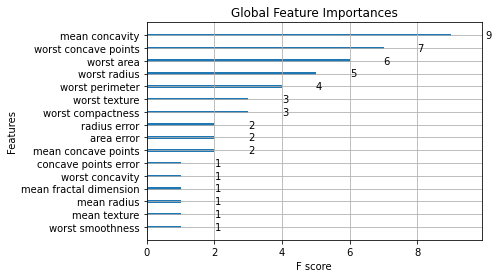

In [ ]:
import matplotlib.pylab as pl
xgb.plot_importance(clf)
pl.title("Global Feature Importances")
pl.show()

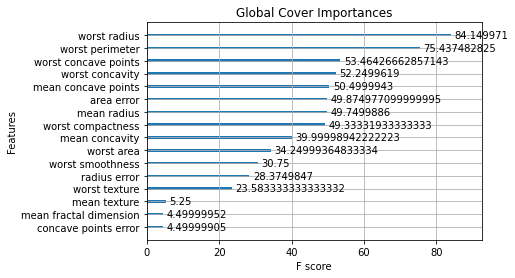

In [ ]:
xgb.plot_importance(clf, importance_type="cover")
pl.title('Global Feature Importances by Cover')
pl.show()

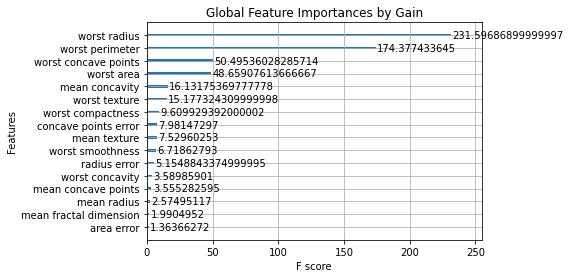

In [ ]:
xgb.plot_importance(clf, importance_type="gain")
pl.title('Global Feature Importances by Gain')
pl.show()

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_X)

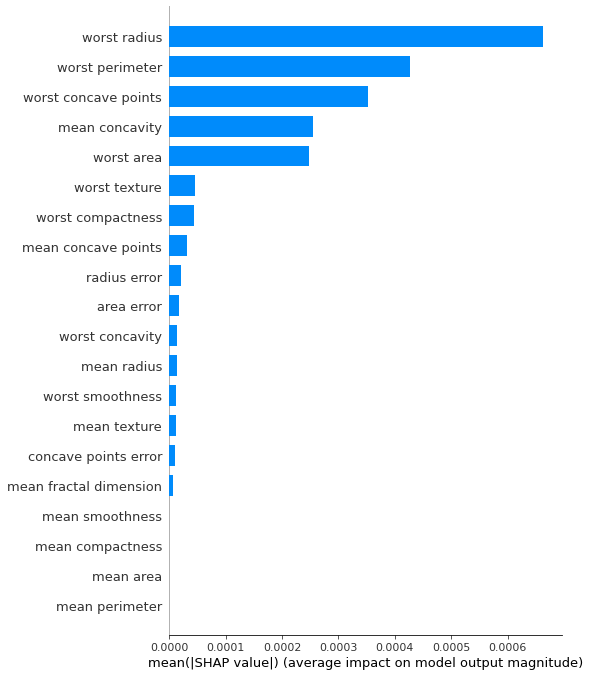

In [ ]:
shap.summary_plot(shap_values, train_X, plot_type="bar")


In [ ]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0,:], train_X.iloc[0,:])

In [ ]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[:1000,:], train_X.iloc[:1000,:])

In [ ]:
for name in train_X.columns:
    shap.dependence_plot(name, shap_values, train_X, display_features=train_X)

# Explain specific record

In [ ]:
data_to_explain = val_X.iloc[0] # picked one record to explain 
print(data_to_explain)

## SHAP Values

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data_to_explain)
print(shap_values)

# SHAP Plot

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_to_explain)